# Install packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q matplotlib scikit-learn spacy

# If en_core_web_sm is not installed, comment in the following line.
# !python -m spacy download en_core_web_sm

# Load Modules

In [3]:
import concurrent.futures
import os
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import spacy
import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

sys.path.append("..")

nlp = spacy.load("en_core_web_sm")

# Data Preparation

In [4]:
n_documents = 1000
n_vocabs = 3000

In [5]:
dataset = fetch_20newsgroups(subset="train")

In [6]:
texts = fetch_20newsgroups(subset="train")["data"][:n_documents]
class_ids = dataset["target"][:n_documents]
labels = np.array([dataset["target_names"][class_id] for class_id in class_ids])

In [7]:
def get_lemmas(text):
    doc = nlp(text)
    return [t.lemma_ for t in doc if t.pos_ not in ["PUNCT", "SPACE"]]


raw_corpus = []
n_batch_size = 1000

# see: https://stackoverflow.com/questions/76292341/concurrent-futures-misbehaves-on-python-3-8-on-mac-os
if sys.platform == "linux":
    for i in tqdm.trange(0, len(texts), n_batch_size):
        with concurrent.futures.ProcessPoolExecutor(
            max_workers=os.cpu_count()
        ) as executor:
            lemmas = list(executor.map(get_lemmas, texts[i : i + n_batch_size]))
            raw_corpus += lemmas
else:
    for text in tqdm.tqdm(texts):
        raw_corpus.append(get_lemmas(text))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


In [8]:
# Build vocabs

words = [word for doc in raw_corpus for word in doc]
word_freq = Counter(words)
vocabs = set([w for w, f in word_freq.most_common(n_vocabs)])

# word_freq.most_common(n_vocabs)[::-1][:100] # for debug

In [9]:
# Build corpus from raw_corpus and vocabs

corpus = []
for raw_doc in tqdm.tqdm(raw_corpus):
    c = []
    for word in raw_doc:
        if word in vocabs:
            c.append(word)
    corpus.append(c)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 52557.57it/s]


# Neural Linear Embedding

In [10]:
# Neural Linear Embedding

from pynle import NeuralLinearEmbedding

n_latent_dimension = 64
nle = NeuralLinearEmbedding(k=n_latent_dimension)
doc_embeddings, word_embeddings = nle.fit_transform(corpus)

[pynle.py:56][INFO][2024-11-26 17:05:59,872] Building PMI matrix (1000, 3000)
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12484.27it/s]
[pynle.py:72][INFO][2024-11-26 17:05:59,955] Executing SVD. Please wait.


# Visualization: Document Embeddings

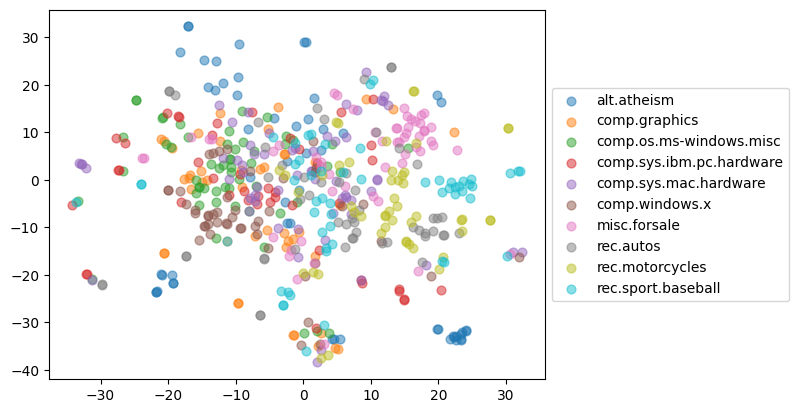

In [11]:
D = TSNE(n_components=2).fit_transform(doc_embeddings)

for i, label_name in enumerate(dataset["target_names"][:10]):
    _ix = labels == label_name
    _D = D[_ix]
    plt.scatter(_D[:, 0], _D[:, 1], s=40, label=label_name, alpha=0.5)

legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=1)

# Visualization: Word Embeddings

In [12]:
def get_similar_words(model, word, word_embeddings, n_top: int = 10) -> list[str]:
    word_id = model.word_to_id[word]
    similar_word_ids = np.argsort(word_embeddings @ word_embeddings[word_id])[::-1][
        :n_top
    ]

    return similar_word_ids, [
        model.id_to_word[similar_word_id] for similar_word_id in similar_word_ids
    ]


# get_similar_words(nle, "computer", word_embeddings, n_top=5)

0: software => ['software', 'Windows', 'disk', 'DOS', 'pc']
1: NASA => ['NASA', 'Space', 'Center', 'Research', 'launch']
2: game => ['game', 'team', 'win', 'season', 'player']


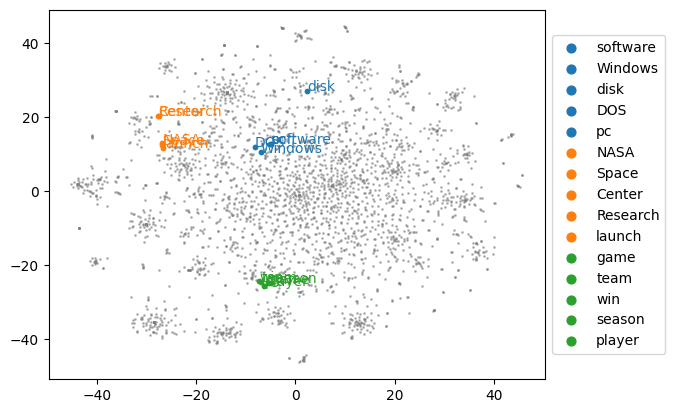

In [13]:
target_words = ["software", "NASA", "game"]

# from sklearn.decomposition import PCA
W = TSNE(n_components=2).fit_transform(word_embeddings)
plt.scatter(W[:, 0], W[:, 1], s=1, c="gray", alpha=0.5)

for i, target_word in enumerate(target_words):
    similar_word_ids, similar_words = get_similar_words(
        nle, target_word, word_embeddings, n_top=5
    )
    for word_id, word in zip(similar_word_ids, similar_words):
        x, y = W[:, 0][word_id], W[:, 1][word_id]
        plt.scatter(x, y, s=10, c=f"C{i}", label=word)
        plt.text(x, y, word, color=f"C{i}")

    print(f"{i}: {target_word} => {similar_words}")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=2)